In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt
from laplace import Laplace

s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


# Load data

Files already downloaded and verified
Files already downloaded and verified


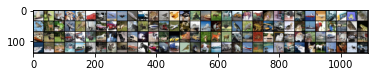

In [4]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


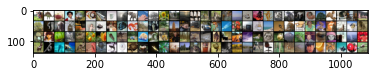

In [5]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


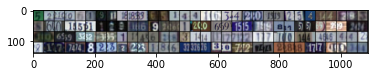

In [6]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [7]:
import torchvision.models as models
SVHN_model = models.resnet18(pretrained=False, num_classes=10).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SVHN_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
best_acc = 0  # best test accuracy

In [9]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [10]:
def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [11]:
def train_all():
    SVHN_path = SVHN_PATH = 'pretrained_weights/SVHN_resnet18_s{}.pth'.format(s)
    SVHN_path_best = SVHN_PATH = 'pretrained_weights/SVHN_resnet18_best_s{}.pth'.format(s)
    lr = 0.1
    epoch = 0
    for e in [10, 10, 5]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, SVHN_train_loader, SVHN_path)
            test(SVHN_model, epoch, SVHN_test_loader, SVHN_path_best, save=True)
            epoch += 1
        lr /= 10

In [12]:
#train_all()

In [13]:
##### if you already have a trained model ##############
#SVHN_PATH = 'pretrained_weights/SVHN_resnet18_pretrained.pth'
SVHN_PATH = 'pretrained_weights/SVHN_resnet18_best_s{}.pth'.format(s)
SVHN_model = models.resnet18(pretrained=False, num_classes=10).to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, SVHN_test_loader, save=False, path=SVHN_PATH)

loading model from: pretrained_weights/SVHN_resnet18_best_s1.pth
test loss:  1.2069596826622728
current acc: 0.9988859864781807; best acc: 0


In [14]:
targets_CIFAR10 = CIFAR10_testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [15]:
#number of samples to draw from the Gaussian
num_samples = 100

# MAP estimate

In [16]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, SVHN_test_loader, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, CIFAR10_test_loader, device=device).cpu().numpy()

In [17]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)

In [18]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')

[In, MAP, SVHN] Accuracy: 0.999; average entropy: 0.017;     MMC: 0.996; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.613;    MMC: 0.788; AUROC: 0.961; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 0.598;    MMC: 0.793; AUROC: 0.959; Prob @ correct: 0.100


# Diagonal estimate

In [19]:
la_diag = Laplace(SVHN_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=1e+1) # 5e-4 # Choose prior precision such that the MMC for inclass is slightly lower than for MAP
la_diag.fit(SVHN_train_loader)

In [20]:
SVHN_test_in_D = predict_samples(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_samples(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_samples(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  5.1677441470000005
time:  2.4389616590000003
time:  0.8157191150000003


In [21]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)

In [22]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'SVHN', 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D,  'SVHN', 'CIFAR10', 'Diag')

[In, Diag, SVHN] Accuracy: 0.999; average entropy: 0.077;     MMC: 0.984; Prob @ correct: 0.100
[Out-CIFAR100, Diag, SVHN] Accuracy: 0.010; Average entropy: 0.613;    MMC: 0.687; AUROC: 0.957; Prob @ correct: 0.100
[Out-CIFAR10, Diag, SVHN] Accuracy: 0.089; Average entropy: 0.907;    MMC: 0.689; AUROC: 0.959; Prob @ correct: 0.100


# KFAC estimate

In [23]:
la_kron = Laplace(SVHN_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='kron',
                     prior_precision=5e-1) # 5e-4 # Choose prior precision according to weight decay
la_kron.fit(SVHN_train_loader)

/home/marius/anaconda3/lib/python3.9/site-packages/laplace/utils.py:137: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  L, W = torch.symeig(M, eigenvectors=True)


In [24]:
SVHN_test_in_K = predict_samples(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_K = predict_samples(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_K = predict_samples(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  7.225593897000003
time:  2.662349556999999
time:  1.0862710829999997


In [25]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(SVHN_test_in_K, targets_SVHN)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR10_K, targets_CIFAR10)

In [26]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'SVHN', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'SVHN', 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K,  'SVHN', 'CIFAR10', 'KFAC')

[In, KFAC, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.983; Prob @ correct: 0.100
[Out-CIFAR100, KFAC, SVHN] Accuracy: 0.010; Average entropy: 0.613;    MMC: 0.655; AUROC: 0.959; Prob @ correct: 0.100
[Out-CIFAR10, KFAC, SVHN] Accuracy: 0.089; Average entropy: 1.001;    MMC: 0.657; AUROC: 0.960; Prob @ correct: 0.100


# Laplace Bridge estimate

In [27]:
SVHN_test_in_LB_D = predict_LB(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_D = predict_LB(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_D = predict_LB(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

step0, f_mu[0]:  tensor([-0.8389, -0.9765, -1.3394, -0.8472, -2.8224, 10.8968, -0.2168, -1.3096,
        -2.3882, -0.1037], device='cuda:0')
step0, f_var[0]:  tensor([[4.7629, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.2728, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.5400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.1568, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.8475, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.5344, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.4597, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8039, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[3.3881, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.9151, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.1997, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.0789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.3244, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5577, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0445, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3760, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3093,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         3

step0, f_mu[0]:  tensor([-4.1509,  1.4813, 13.0620,  0.5176,  0.7691, -2.7817, -3.7758, -0.4959,
        -2.3427, -2.3868], device='cuda:0')
step0, f_var[0]:  tensor([[6.0899, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.4652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.0675, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.3979, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7212, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.0965, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.5298, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.2282, 10.9810,  0.4264, -1.5001, -0.4353, -1.5626, -2.4663, -1.9319,
        -1.1033, -1.1827], device='cuda:0')
step0, f_var[0]:  tensor([[3.3901, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.8338, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.6934, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.8693, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.0349, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3116, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4017, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0707, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[4.5028, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.0300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.8401, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.6771, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.4761, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.4423, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8630, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.8593, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.1719,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         3

step0, f_mu[0]:  tensor([-1.7215, -0.1838, -1.7188, -1.1774, -1.9510, 12.0619, -1.1873, -1.8571,
        -2.6611,  0.4817], device='cuda:0')
step0, f_var[0]:  tensor([[6.3452, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.5478, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.9310, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.4276, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 6.1668, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.6060, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.9235, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4692, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.6104, -1.1273, -1.3497, -0.5712, -2.0600, -0.1233,  1.2429, -4.3916,
        11.1769, -0.1707], device='cuda:0')
step0, f_var[0]:  tensor([[5.2713, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.8352, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.0728, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.5485, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.3160, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9765, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.4568, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.8475, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.6817,  0.7254, -0.8298,  0.9999, -1.8708, -2.2525, -1.1843, -4.7692,
        10.4979,  1.3684], device='cuda:0')
step0, f_var[0]:  tensor([[5.9032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.1442, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.5262, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.8877, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.8366, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7825, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3953, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4930, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.8011, -2.4395,  0.5340, -0.2186, -1.2411, -1.5557, -0.4399, -3.5452,
        11.3309,  0.3772], device='cuda:0')
step0, f_var[0]:  tensor([[5.7405, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.1134, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.1287, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.7054, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.5652, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.5585, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.1881, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.1767, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[2.5526, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.4927, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.0982, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.2154, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.1987, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4755, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5792, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0482, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4751,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         2

step0, f_mu[0]:  tensor([-2.4420,  1.6702, -0.2995, 11.3427, -1.3510,  0.1490, -3.8808, -2.3816,
        -1.2165, -1.5886], device='cuda:0')
step0, f_var[0]:  tensor([[5.2550, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.9438, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.5123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.3318, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.1665, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.4900, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.2661, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.1968, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[2.7042, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.4671, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.2117, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.3372, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.3976, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5778, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5788, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2303, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5419,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         2

step0, f_mu[0]:  tensor([-1.0884,  7.7986,  1.3096, -2.5481, -0.6036,  0.0264, -1.8535, -0.7382,
        -1.2065, -1.0885], device='cuda:0')
step0, f_var[0]:  tensor([[2.4405, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.3741, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.8595, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.1218, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.1389, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2312, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.3604, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.1023, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-0.5961,  0.5035,  0.0676, -0.9194, -1.5741, -1.5954, -3.2168, 11.0945,
        -3.2782, -0.5579], device='cuda:0')
step0, f_var[0]:  tensor([[4.7947, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.5164, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.1078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.3619, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.7359, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.6448, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9444, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3299, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[2.9906, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.6085, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.3074, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6265, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.6284, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8668, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.9373, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4825, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8418,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         2

step0, f_mu[0]:  tensor([ 9.6109, -3.7006, -1.2910, -0.2756, -0.5347,  1.0953,  0.0713, -2.5796,
        -1.3643, -1.1316], device='cuda:0')
step0, f_var[0]:  tensor([[3.1985, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.3847, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.5707, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.1850, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.6322, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.2130, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9151, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9078, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([10.6728, -3.5596, -1.9981, -0.6939, -0.9043,  0.8643,  0.5833, -2.3394,
        -0.9425, -1.7998], device='cuda:0')
step0, f_var[0]:  tensor([[3.7244, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.1275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.4557, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.9614, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.4837, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0150, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.5291, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.7924, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.1857,  1.0379,  1.3031,  9.5652, -2.4564,  0.9624, -3.2926, -1.3788,
        -1.6445, -1.9126], device='cuda:0')
step0, f_var[0]:  tensor([[4.1042, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.1276, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.4691, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6608, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.0996, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4612, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0753, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0179, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.5588, -2.5478, -2.5881, -1.6060, -2.2139, -2.0131,  1.7896, -4.8457,
        15.3523,  0.2038], device='cuda:0')
step0, f_var[0]:  tensor([[ 8.7544,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  8.2155,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  8.6842,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  7.7471,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  8.9692,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  8.7887,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  7.5805,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.006

step0, f_var[0]:  tensor([[5.3578, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 5.3974, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.9960, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.0038, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.9389, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.5571, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.5434, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.6171, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9338,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         5

step0, f_mu[0]:  tensor([-2.7813, -1.8532, -1.4838,  1.2433, -2.1524, -1.9861, -0.8874, -4.4516,
        13.3497,  1.0211], device='cuda:0')
step0, f_var[0]:  tensor([[7.1488, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 6.3968, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 6.6673, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.7743, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 7.0970, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.9894, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.4968, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7.8660, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.0844, -0.5575, -0.8065, -1.6418, 11.7671, -1.6142, -0.4742, -1.7743,
        -0.7928, -2.0709], device='cuda:0')
step0, f_var[0]:  tensor([[5.2809, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.2361, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 4.6881, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 4.8543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.9458, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9566, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.0633, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.3652, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 0.2715,  0.4366, -1.8531, -1.8540, -2.4689, -0.4552, 11.1610, -2.7695,
         0.1527, -2.7498], device='cuda:0')
step0, f_var[0]:  tensor([[4.9422, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 4.8864, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 5.4764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 5.1475, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 5.4251, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9494, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0421, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5.6474, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.3071,  1.8029,  2.8668,  7.2152,  0.0766, -1.9591, -3.6919, -2.6893,
        -0.1650, -1.1490], device='cuda:0')
step0, f_var[0]:  tensor([[3.5826, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.6748, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.9069, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.4662, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.4093, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.2866, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6332, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.5449, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-3.1236,  4.3010,  2.1141, -2.7178,  2.2846,  1.7853, -1.6634, -2.9196,
        -0.2031,  0.1834], device='cuda:0')
step0, f_var[0]:  tensor([[2.4645, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.6585, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.9245, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.1482, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0103, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.1312, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2954, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4258, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-1.6858,  0.0638,  3.9128,  0.6799, -1.8930, -2.1751, -3.1118,  2.0055,
        -0.6181,  2.7916], device='cuda:0')
step0, f_var[0]:  tensor([[2.4124, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.9885, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.9123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.0347, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.4056, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4039, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5288, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2368, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[2.2827, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.1558, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.3826, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.1743, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.6514, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4869, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5302, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7539, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.5253,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         2

step0, f_mu[0]:  tensor([-0.8340,  1.5978, -1.3828, -0.7865,  6.0251, -1.1969, -0.8155, -0.4170,
        -0.1025, -2.1379], device='cuda:0')
step0, f_var[0]:  tensor([[2.0556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.5867, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.8902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.9084, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.6167, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.9866, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.9782, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0859, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.9518, -0.5500,  1.8857, -1.0852,  4.3629,  1.1723, -2.3348,  1.6061,
        -1.6846, -0.4295], device='cuda:0')
step0, f_var[0]:  tensor([[2.4655, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.9348, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.0283, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.1702, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0328, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.1759, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4004, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2572, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-2.1709, -0.6561,  7.3197,  1.6739,  0.2951, -1.9176, -2.1731,  1.8119,
        -0.7477, -3.5027], device='cuda:0')
step0, f_var[0]:  tensor([[3.1766, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.5378, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.3768, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6722, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.9752, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0534, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.1527, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8634, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[3.7508, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.0872, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.4473, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.7808, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4896, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7887, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9386, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3173,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         3

step0, f_mu[0]:  tensor([-2.3337, -0.7213,  2.9671, -0.5600, -0.7725,  1.3865, -2.7226, -1.3777,
        -2.2443,  6.4294], device='cuda:0')
step0, f_var[0]:  tensor([[3.0522, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.7190, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.5904, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6486, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.9955, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8175, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.2179, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.1976, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_var[0]:  tensor([[2.4086, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.9774, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.9414, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.9296, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.2627, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2118, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4398, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.3363, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2528,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         2

step0, f_mu[0]:  tensor([-2.3784,  0.9993,  9.2718,  3.1652, -1.7143, -1.8442, -3.4121, -1.8429,
        -2.5418,  0.2703], device='cuda:0')
step0, f_var[0]:  tensor([[3.8071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.9212, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.7232, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.0030, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.6637, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6201, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9362, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6795, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-4.2797, -2.5371,  2.8188,  1.2738,  2.5178,  0.2222, -1.0587, -2.8701,
         3.3680,  0.5840], device='cuda:0')
step0, f_var[0]:  tensor([[3.3355, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.8225, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.7563, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.6918, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.9384, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0279, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.1294, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4279, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-0.5583, -3.4205, -1.0113, -0.6420, -3.2573,  4.0093, -0.0145, -3.4255,
         2.6742,  5.7087], device='cuda:0')
step0, f_var[0]:  tensor([[3.7656, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.7063, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.6734, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.3001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.9740, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3606, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.6632, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.2684, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 3.7905,  0.1245, -2.1030,  2.7916, -2.0021, -1.9816,  3.9906, -2.7596,
         0.1768, -2.1547], device='cuda:0')
step0, f_var[0]:  tensor([[2.5292, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.6292, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.0106, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.5250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.0299, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8060, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4122, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.1669, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([ 0.0586,  1.6360, -2.6791,  7.8163, -1.5892, -2.9972, -3.4110,  2.4595,
         0.5224, -1.8509], device='cuda:0')
step0, f_var[0]:  tensor([[4.1193, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.2210, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.8632, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.0180, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.2437, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0590, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.2100, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9085, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-4.7322,  0.7848,  4.2214, -1.8118,  7.0145, -0.9029, -3.1315, -2.2952,
        -0.7133,  1.5876], device='cuda:0')
step0, f_var[0]:  tensor([[4.1002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 3.0952, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 3.1571, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 3.5074, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 3.1027, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7394, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.9993, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.0537, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

step0, f_mu[0]:  tensor([-3.9319,  1.7601,  4.2491, -2.0278,  3.6625,  1.0168, -0.3065, -2.8176,
         1.3943, -3.0120], device='cuda:0')
step0, f_var[0]:  tensor([[2.9618, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 2.1645, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 2.2729, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 2.5781, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.3715, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.6061, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.6782, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.8929, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [28]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(SVHN_test_in_LB_D, targets_SVHN)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(SVHN_test_in_LB_D, SVHN_test_out_CIFAR100_LB_D, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(SVHN_test_in_LB_D, SVHN_test_out_CIFAR10_LB_D, targets_CIFAR10)

In [29]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB,  'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB,  'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.026;     MMC: 0.995; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.010; Average entropy: 0.839;    MMC: 0.739; AUROC: 0.962; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.803;    MMC: 0.749; AUROC: 0.960; Prob @ correct: 0.100


# LB diag norm

In [45]:
SVHN_test_in_LB_Dn = predict_LB_norm(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_Dn = predict_LB_norm(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_Dn = predict_LB_norm(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.384215197000003
time:  1.6000106630000062
time:  0.6044403009999968


In [46]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(SVHN_test_in_LB_Dn, targets_SVHN)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(SVHN_test_in_LB_Dn, SVHN_test_out_CIFAR100_LB_Dn, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(SVHN_test_in_LB_Dn, SVHN_test_out_CIFAR10_LB_Dn, targets_CIFAR10)

In [47]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB,  'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB,  'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.028;     MMC: 0.995; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.010; Average entropy: 0.602;    MMC: 0.807; AUROC: 0.945; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.598;    MMC: 0.808; AUROC: 0.947; Prob @ correct: 0.100


# Laplace Bridge KFAC

In [30]:
SVHN_test_in_LB_KFAC = predict_LB(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_KFAC = predict_LB(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_KFAC = predict_LB(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

step0, f_mu[0]:  tensor([-0.8389, -0.9765, -1.3394, -0.8472, -2.8224, 10.8968, -0.2168, -1.3096,
        -2.3882, -0.1037], device='cuda:0')
step0, f_var[0]:  tensor([[12.6848, 10.5300, 10.4904, 10.5354, 10.4822, 10.5816, 10.7276, 10.4214,
         10.5539, 10.6185],
        [10.5300, 11.8939, 10.7466, 10.6983, 10.6693, 10.5897, 10.5709, 10.7968,
         10.5629, 10.5674],
        [10.4904, 10.7466, 12.2380, 10.6334, 10.6365, 10.5485, 10.4689, 10.7141,
         10.5208, 10.6286],
        [10.5354, 10.6983, 10.6334, 12.1278, 10.5090, 10.7124, 10.5643, 10.5443,
         10.6441, 10.6568],
        [10.4822, 10.6693, 10.6365, 10.5090, 12.7370, 10.5225, 10.4879, 10.4885,
         10.5643, 10.5287],
        [10.5816, 10.5897, 10.5485, 10.7124, 10.5225, 12.3057, 10.7203, 10.4664,
         10.5975, 10.5813],
        [10.7276, 10.5709, 10.4689, 10.5643, 10.4879, 10.7203, 12.4595, 10.4025,
         10.7432, 10.4808],
        [10.4214, 10.7968, 10.7141, 10.5443, 10.4885, 10.4664, 10.4025, 12.919

step0, f_mu[0]:  tensor([-2.5906,  1.6224, 11.8253, -0.6942, -0.2467, -2.1211, -3.8401, -1.2537,
        -2.4464, -0.3346], device='cuda:0')
step0, f_var[0]:  tensor([[12.5169, 10.2841, 10.2476, 10.2864, 10.2405, 10.3272, 10.4604, 10.1888,
         10.3013, 10.3628],
        [10.2841, 11.7691, 10.4867, 10.4434, 10.4125, 10.3383, 10.3231, 10.5285,
         10.3136, 10.3166],
        [10.2476, 10.4867, 12.1039, 10.3780, 10.3788, 10.2994, 10.2272, 10.4463,
         10.2744, 10.3736],
        [10.2864, 10.4434, 10.3780, 11.9999, 10.2615, 10.4533, 10.3119, 10.2942,
         10.3881, 10.3994],
        [10.2405, 10.4125, 10.3788, 10.2615, 12.5647, 10.2758, 10.2446, 10.2429,
         10.3139, 10.2808],
        [10.3272, 10.3383, 10.2994, 10.4533, 10.2758, 12.1691, 10.4571, 10.2262,
         10.3413, 10.3284],
        [10.4604, 10.3231, 10.2272, 10.3119, 10.2446, 10.4571, 12.3084, 10.1712,
         10.4767, 10.2354],
        [10.1888, 10.5285, 10.4463, 10.2942, 10.2429, 10.2262, 10.1712, 12.719

step0, f_mu[0]:  tensor([-2.8271,  0.5145, -0.4569, -2.8694, 10.8698, -0.5121, -1.3848, -2.3675,
         0.4830, -1.4478], device='cuda:0')
step0, f_var[0]:  tensor([[12.3816, 10.1895, 10.1546, 10.1918, 10.1478, 10.2310, 10.3582, 10.0979,
         10.2063, 10.2647],
        [10.1895, 11.6657, 10.3837, 10.3423, 10.3124, 10.2412, 10.2269, 10.4236,
         10.2177, 10.2205],
        [10.1546, 10.3836, 11.9872, 10.2791, 10.2800, 10.2040, 10.1350, 10.3447,
         10.1802, 10.2749],
        [10.1918, 10.3423, 10.2791, 11.8876, 10.1679, 10.3511, 10.2160, 10.1991,
         10.2888, 10.2996],
        [10.1478, 10.3124, 10.2800, 10.1679, 12.4270, 10.1816, 10.1518, 10.1504,
         10.2180, 10.1864],
        [10.2310, 10.2412, 10.2040, 10.3511, 10.1816, 12.0495, 10.3548, 10.1340,
         10.2442, 10.2320],
        [10.3582, 10.2269, 10.1350, 10.2160, 10.1518, 10.3548, 12.1827, 10.0811,
         10.3736, 10.1433],
        [10.0979, 10.4236, 10.3447, 10.1991, 10.1504, 10.1340, 10.0811, 12.576

step0, f_mu[0]:  tensor([-2.4495,  1.6868, 11.3084, -0.8615,  0.3764, -1.7031, -3.5821, -0.6249,
        -1.9503, -2.2802], device='cuda:0')
step0, f_var[0]:  tensor([[10.6773,  9.5092,  9.4886,  9.5127,  9.4843,  9.5371,  9.6133,  9.4515,
          9.5230,  9.5559],
        [ 9.5092, 10.2701,  9.6213,  9.5960,  9.5816,  9.5404,  9.5302,  9.6484,
          9.5265,  9.5291],
        [ 9.4886,  9.6213, 10.4457,  9.5631,  9.5653,  9.5192,  9.4776,  9.6066,
          9.5047,  9.5607],
        [ 9.5127,  9.5960,  9.5631, 10.3889,  9.4991,  9.6037,  9.5279,  9.5173,
          9.5687,  9.5754],
        [ 9.4843,  9.5816,  9.5653,  9.4991, 10.7043,  9.5057,  9.4875,  9.4884,
          9.5274,  9.5091],
        [ 9.5371,  9.5404,  9.5192,  9.6037,  9.5057, 10.4802,  9.6086,  9.4760,
          9.5455,  9.5365],
        [ 9.6133,  9.5302,  9.4776,  9.5279,  9.4875,  9.6086, 10.5606,  9.4417,
          9.6208,  9.4846],
        [ 9.4515,  9.6484,  9.6066,  9.5173,  9.4884,  9.4760,  9.4417, 10.802

step0, f_mu[0]:  tensor([-0.9052, -0.7900,  1.7073, -0.5983, -1.5870, -2.1067, -3.0001,  8.6492,
        -0.7622, -0.6841], device='cuda:0')
step0, f_var[0]:  tensor([[11.2059,  8.0250,  7.9766,  8.0266,  7.9674,  8.0799,  8.2558,  7.9010,
          8.0452,  8.1278],
        [ 8.0250, 10.2030,  8.2956,  8.2388,  8.1955,  8.0963,  8.0776,  8.3486,
          8.0637,  8.0669],
        [ 7.9766,  8.2956, 10.6572,  8.1488,  8.1488,  8.0443,  7.9491,  8.2363,
          8.0115,  8.1429],
        [ 8.0266,  8.2388,  8.1488, 10.5179,  7.9932,  8.2500,  8.0597,  8.0368,
          8.1623,  8.1771],
        [ 7.9674,  8.1955,  8.1488,  7.9932, 11.2691,  8.0133,  7.9722,  7.9688,
          8.0635,  8.0194],
        [ 8.0799,  8.0963,  8.0443,  8.2500,  8.0133, 10.7453,  8.2531,  7.9485,
          8.0981,  8.0823],
        [ 8.2558,  8.0776,  7.9491,  8.0597,  7.9722,  8.2531, 10.9289,  7.8776,
          8.2785,  7.9586],
        [ 7.9010,  8.3486,  8.2363,  8.0368,  7.9688,  7.9485,  7.8776, 11.467

step0, f_mu[0]:  tensor([-3.3707, -0.1249,  2.2840, -0.3971,  8.6940, -0.6235, -1.4307, -2.3218,
        -1.1571, -1.5674], device='cuda:0')
step0, f_var[0]:  tensor([[10.1616,  7.9581,  7.9261,  7.9598,  7.9199,  7.9954,  8.1120,  7.8750,
          7.9726,  8.0267],
        [ 7.9581,  9.5018,  8.1366,  8.0989,  8.0709,  8.0054,  7.9926,  8.1726,
          7.9839,  7.9862],
        [ 7.9261,  8.1366,  9.7993,  8.0401,  8.0406,  7.9712,  7.9080,  8.0994,
          7.9494,  8.0363],
        [ 7.9598,  8.0989,  8.0401,  9.7076,  7.9378,  8.1067,  7.9818,  7.9665,
          8.0491,  8.0590],
        [ 7.9199,  8.0709,  8.0406,  7.9378, 10.2034,  7.9506,  7.9234,  7.9216,
          7.9840,  7.9549],
        [ 7.9954,  8.0054,  7.9712,  8.1067,  7.9506,  9.8569,  8.1095,  7.9073,
          8.0075,  7.9966],
        [ 8.1120,  7.9926,  7.9080,  7.9818,  7.9234,  8.1095,  9.9788,  7.8595,
          8.1265,  7.9150],
        [ 7.8750,  8.1726,  8.0994,  7.9665,  7.9216,  7.9073,  7.8595, 10.337

step0, f_mu[0]:  tensor([-0.2432, -0.1511, -2.3918, -0.8568, -1.7352,  8.4318,  2.1456, -0.3251,
        -3.6212, -1.2557], device='cuda:0')
step0, f_var[0]:  tensor([[12.3567,  7.8476,  7.7824,  7.8469,  7.7702,  7.9171,  8.1527,  7.6851,
          7.8698,  7.9831],
        [ 7.8476, 10.9850,  8.2155,  8.1403,  8.0775,  7.9427,  7.9198,  8.2824,
          7.8989,  7.9019],
        [ 7.7824,  8.2155, 11.6159,  8.0129,  8.0109,  7.8717,  7.7446,  8.1247,
          7.8281,  8.0049],
        [ 7.8469,  8.1402,  8.0129, 11.4256,  7.8013,  8.1520,  7.8904,  7.8602,
          8.0313,  8.0509],
        [ 7.7702,  8.0775,  8.0109,  7.8013, 12.4414,  7.8303,  7.7757,  7.7689,
          7.8976,  7.8378],
        [ 7.9171,  7.9427,  7.8717,  8.1520,  7.8303, 11.7375,  8.1526,  7.7451,
          7.9409,  7.9218],
        [ 8.1527,  7.9198,  7.7446,  7.8904,  7.7757,  8.1526, 11.9826,  7.6534,
          8.1853,  7.7546],
        [ 7.6851,  8.2824,  8.1247,  7.8602,  7.7689,  7.7451,  7.6534, 12.695

step0, f_mu[0]:  tensor([-2.6104, -1.1273, -1.3497, -0.5712, -2.0600, -0.1233,  1.2429, -4.3916,
        11.1769, -0.1707], device='cuda:0')
step0, f_var[0]:  tensor([[16.5067, 12.1488, 12.0718, 12.1556, 12.0562, 12.2433, 12.5259, 11.9443,
         12.1885, 12.3173],
        [12.1488, 14.9453, 12.5734, 12.4808, 12.4196, 12.2641, 12.2299, 12.6655,
         12.2120, 12.2191],
        [12.0718, 12.5734, 15.6346, 12.3486, 12.3519, 12.1827, 12.0291, 12.4976,
         12.1294, 12.3392],
        [12.1556, 12.4808, 12.3486, 15.4174, 12.1037, 12.5053, 12.2108, 12.1730,
         12.3694, 12.3938],
        [12.0562, 12.4196, 12.3519, 12.1037, 16.6086, 12.1322, 12.0659, 12.0637,
         12.2132, 12.1433],
        [12.2433, 12.2641, 12.1827, 12.5053, 12.1322, 15.7701, 12.5162, 12.0260,
         12.2737, 12.2448],
        [12.5259, 12.2299, 12.0291, 12.2108, 12.0659, 12.5162, 16.0663, 11.9071,
         12.5590, 12.0481],
        [11.9443, 12.6655, 12.4976, 12.1730, 12.0637, 12.0260, 11.9071, 16.944

step0, f_mu[0]:  tensor([-1.7138,  1.7298, 10.3837, -1.0957, -0.4950, -1.6480, -3.3314, -0.7815,
        -1.4714, -1.6448], device='cuda:0')
step0, f_var[0]:  tensor([[9.3927, 8.1640, 8.1416, 8.1670, 8.1370, 8.1931, 8.2759, 8.1027, 8.1774,
         8.2141],
        [8.1640, 8.9432, 8.2871, 8.2597, 8.2431, 8.1979, 8.1873, 8.3153, 8.1827,
         8.1852],
        [8.1416, 8.2871, 9.1392, 8.2226, 8.2243, 8.1744, 8.1294, 8.2681, 8.1588,
         8.2199],
        [8.1670, 8.2597, 8.2226, 9.0766, 8.1520, 8.2676, 8.1833, 8.1720, 8.2287,
         8.2359],
        [8.1370, 8.2431, 8.2243, 8.1520, 9.4223, 8.1597, 8.1401, 8.1403, 8.1834,
         8.1632],
        [8.1931, 8.1979, 8.1744, 8.2675, 8.1597, 9.1777, 8.2719, 8.1280, 8.2021,
         8.1930],
        [8.2759, 8.1873, 8.1294, 8.1833, 8.1401, 8.2719, 9.2648, 8.0919, 8.2848,
         8.1360],
        [8.1027, 8.3153, 8.2681, 8.1720, 8.1403, 8.1280, 8.0919, 9.5250, 8.0950,
         8.1270],
        [8.1774, 8.1827, 8.1588, 8.2287, 8.1834, 

step0, f_mu[0]:  tensor([-1.8997,  1.8137, -0.5254, 12.7408, -1.7621, -2.3605, -4.2655, -1.0256,
        -0.3654, -2.3695], device='cuda:0')
step0, f_var[0]:  tensor([[16.7936, 14.5801, 14.5384, 14.5870, 14.5296, 14.6363, 14.7908, 14.4640,
         14.6073, 14.6746],
        [14.5801, 15.9704, 14.8065, 14.7551, 14.7266, 14.6435, 14.6225, 14.8614,
         14.6152, 14.6205],
        [14.5384, 14.8065, 16.3236, 14.6898, 14.6938, 14.6004, 14.5161, 14.7773,
         14.5710, 14.6847],
        [14.5870, 14.7551, 14.6898, 16.2088, 14.5595, 14.7717, 14.6181, 14.5967,
         14.7008, 14.7144],
        [14.5296, 14.7266, 14.6939, 14.5595, 16.8490, 14.5728, 14.5361, 14.5375,
         14.6171, 14.5797],
        [14.6363, 14.6435, 14.6004, 14.7717, 14.5728, 16.3937, 14.7816, 14.5130,
         14.6535, 14.6354],
        [14.7908, 14.6225, 14.5161, 14.6181, 14.5361, 14.7816, 16.5565, 14.4441,
         14.8063, 14.5297],
        [14.4640, 14.8614, 14.7773, 14.5967, 14.5375, 14.5130, 14.4440, 17.046

step0, f_mu[0]:  tensor([-1.4359,  0.3282, -1.4840, -1.4895, -1.3556,  9.8139, -0.0375, -1.9713,
        -2.0802, -0.2055], device='cuda:0')
step0, f_var[0]:  tensor([[10.4996,  8.8703,  8.8402,  8.8756,  8.8338,  8.9115,  9.0231,  8.7858,
          8.8906,  8.9389],
        [ 8.8703,  9.9065,  9.0337,  8.9965,  8.9762,  8.9161,  8.9008,  9.0738,
          8.8957,  8.8997],
        [ 8.8402,  9.0337, 10.1605,  8.9495,  8.9528,  8.8851,  8.8242,  9.0135,
          8.8638,  8.9460],
        [ 8.8756,  8.9965,  8.9495, 10.0777,  8.8558,  9.0085,  8.8981,  8.8825,
          8.9576,  8.9674],
        [ 8.8338,  8.9762,  8.9528,  8.8558, 10.5395,  8.8652,  8.8386,  8.8400,
          8.8972,  8.8703],
        [ 8.9115,  8.9161,  8.8851,  9.0085,  8.8652, 10.2108,  9.0161,  8.8217,
          8.9238,  8.9106],
        [ 9.0231,  8.9008,  8.8242,  8.8981,  8.8386,  9.0161, 10.3287,  8.7714,
          9.0340,  8.8344],
        [ 8.7858,  9.0738,  9.0135,  8.8825,  8.8400,  8.8217,  8.7714, 10.683

step0, f_mu[0]:  tensor([-2.9444e-02, -4.0995e-01,  5.2098e-01, -1.6516e+00, -1.3805e+00,
        -1.0280e-02, -3.0356e+00,  1.1584e+01, -3.7898e+00, -1.8824e+00],
       device='cuda:0')
step0, f_var[0]:  tensor([[14.3795, 11.8256, 11.7786, 11.8315, 11.7691, 11.8860, 12.0590, 11.6978,
         11.8531, 11.9300],
        [11.8256, 13.4376, 12.0832, 12.0262, 11.9909, 11.8963, 11.8744, 12.1418,
         11.8645, 11.8697],
        [11.7786, 12.0832, 13.8493, 11.9480, 11.9513, 11.8472, 11.7531, 12.0426,
         11.8145, 11.9424],
        [11.8315, 12.0262, 11.9480, 13.7181, 11.8001, 12.0422, 11.8656, 11.8420,
         11.9607, 11.9758],
        [11.7691, 11.9909, 11.9513, 11.8001, 14.4414, 11.8164, 11.7756, 11.7758,
         11.8659, 11.8237],
        [11.8860, 11.8963, 11.8472, 12.0422, 11.8164, 13.9302, 12.0509, 11.7503,
         11.9047, 11.8859],
        [12.0590, 11.8744, 11.7531, 11.8656, 11.7756, 12.0509, 14.1121, 11.6752,
         12.0778, 11.7666],
        [11.6978, 12.1418, 12.0

step0, f_mu[0]:  tensor([-2.0570, -3.1089,  0.6952,  0.8117, -1.7684,  0.2529, -4.7701, -2.7569,
        -0.4142, 13.2515], device='cuda:0')
step0, f_var[0]:  tensor([[21.8412, 17.1373, 17.0610, 17.1447, 17.0460, 17.2316, 17.5107, 16.9331,
         17.1782, 17.3041],
        [17.1373, 20.2893, 17.5601, 17.4690, 17.4064, 17.2509, 17.2182, 17.6507,
         17.1995, 17.2067],
        [17.0610, 17.5601, 20.9806, 17.3340, 17.3377, 17.1704, 17.0188, 17.4825,
         17.1179, 17.3250],
        [17.1447, 17.4690, 17.3340, 20.7644, 17.0928, 17.4898, 17.1982, 17.1606,
         17.3555, 17.3791],
        [17.0460, 17.4064, 17.3377, 17.0928, 21.9404, 17.1214, 17.0555, 17.0544,
         17.2011, 17.1325],
        [17.2316, 17.2509, 17.1704, 17.4898, 17.1214, 21.1145, 17.5005, 17.0155,
         17.2609, 17.2325],
        [17.5107, 17.2182, 17.0188, 17.1982, 17.0555, 17.5005, 21.4075, 16.8964,
         17.5427, 17.0394],
        [16.9331, 17.6507, 17.4825, 17.1606, 17.0544, 17.0155, 16.8964, 22.277

step0, f_mu[0]:  tensor([-2.0555, -1.1336,  1.6004,  0.6587, -0.9165, -0.1697, -3.6210, -3.7206,
         0.8922,  8.5624], device='cuda:0')
step0, f_var[0]:  tensor([[12.6473,  8.9919,  8.9344,  8.9939,  8.9234,  9.0573,  9.2662,  8.8444,
          9.0161,  9.1140],
        [ 8.9919, 11.4576,  9.3130,  9.2456,  9.1943,  9.0766,  9.0542,  9.3762,
          9.0379,  9.0418],
        [ 8.9344,  9.3130, 11.9961,  9.1389,  9.1390,  9.0149,  8.9018,  9.2431,
          8.9759,  9.1319],
        [ 8.9939,  9.2456,  9.1389, 11.8308,  8.9543,  9.2590,  9.0333,  9.0060,
          9.1549,  9.1725],
        [ 8.9234,  9.1943,  9.1390,  8.9543, 12.7222,  8.9780,  8.9293,  8.9254,
          9.0377,  8.9854],
        [ 9.0573,  9.0766,  9.0149,  9.2590,  8.9780, 12.1005,  9.2629,  8.9010,
          9.0789,  9.0600],
        [ 9.2662,  9.0542,  8.9018,  9.0333,  8.9293,  9.2629, 12.3185,  8.8166,
          9.2930,  8.9132],
        [ 8.8444,  9.3762,  9.2431,  9.0060,  8.9254,  8.9010,  8.8166, 12.958

step0, f_mu[0]:  tensor([-1.1287,  0.9734, -0.4073, 12.0740, -1.4344, -0.1338, -3.0456, -1.2829,
        -2.6472, -2.9930], device='cuda:0')
step0, f_var[0]:  tensor([[16.5962, 13.7580, 13.7052, 13.7647, 13.6943, 13.8260, 14.0209, 13.6145,
         13.7888, 13.8757],
        [13.7580, 15.5408, 14.0465, 13.9821, 13.9435, 13.8378, 13.8125, 14.1131,
         13.8019, 13.8078],
        [13.7052, 14.0465, 15.9992, 13.8962, 13.8999, 13.7826, 13.6765, 14.0027,
         13.7456, 13.8897],
        [13.7647, 13.9821, 13.8962, 15.8522, 13.7296, 14.0015, 13.8035, 13.7769,
         13.9101, 13.9272],
        [13.6943, 13.9435, 13.8999, 13.7296, 16.6665, 13.7476, 13.7017, 13.7018,
         13.8035, 13.7558],
        [13.8260, 13.8378, 13.7826, 14.0015, 13.7476, 16.0899, 14.0117, 13.6734,
         13.8475, 13.8260],
        [14.0209, 13.8125, 13.6765, 13.8035, 13.7017, 14.0117, 16.2947, 13.5891,
         14.0421, 13.6914],
        [13.6145, 14.1131, 14.0027, 13.7769, 13.7018, 13.6734, 13.5891, 16.906

step0, f_mu[0]:  tensor([-0.0190, -3.0588, -3.5473,  2.1201, -1.6499, -0.2773,  0.0781, -4.2449,
        10.8894, -0.2923], device='cuda:0')
step0, f_var[0]:  tensor([[16.7785, 12.7041, 12.6384, 12.7078, 12.6256, 12.7812, 13.0209, 12.5329,
         12.7344, 12.8454],
        [12.7041, 15.4275, 13.0699, 12.9921, 12.9356, 12.8015, 12.7747, 13.1445,
         12.7572, 12.7622],
        [12.6384, 13.0699, 16.0343, 12.8730, 12.8742, 12.7313, 12.6014, 12.9953,
         12.6864, 12.8650],
        [12.7078, 12.9921, 12.8730, 15.8465, 12.6628, 13.0091, 12.7535, 12.7218,
         12.8912, 12.9115],
        [12.6256, 12.9356, 12.8742, 12.6628, 16.8644, 12.6889, 12.6328, 12.6296,
         12.7575, 12.6978],
        [12.7812, 12.8015, 12.7313, 13.0091, 12.6889, 16.1523, 13.0153, 12.5998,
         12.8063, 12.7835],
        [13.0209, 12.7747, 12.6014, 12.7535, 12.6328, 13.0153, 16.4029, 12.5011,
         13.0506, 12.6159],
        [12.5329, 13.1445, 12.9953, 12.7218, 12.6295, 12.5998, 12.5011, 17.141

step0, f_mu[0]:  tensor([-0.2038, 10.1732, -1.0028, -2.4284, -0.5708, -2.0930, -1.9480,  0.7556,
        -1.1156, -1.6026], device='cuda:0')
step0, f_var[0]:  tensor([[9.1729, 7.1484, 7.1193, 7.1493, 7.1138, 7.1813, 7.2870, 7.0738, 7.1605,
         7.2101],
        [7.1484, 8.5677, 7.3117, 7.2777, 7.2511, 7.1912, 7.1802, 7.3433, 7.1716,
         7.1735],
        [7.1193, 7.3117, 8.8430, 7.2226, 7.2226, 7.1599, 7.1027, 7.2751, 7.1402,
         7.2191],
        [7.1493, 7.2777, 7.2226, 8.7590, 7.1291, 7.2838, 7.1690, 7.1552, 7.2309,
         7.2397],
        [7.1138, 7.2511, 7.2226, 7.1291, 9.2107, 7.1413, 7.1166, 7.1146, 7.1715,
         7.1450],
        [7.1813, 7.1912, 7.1599, 7.2838, 7.1413, 8.8961, 7.2855, 7.1024, 7.1921,
         7.1827],
        [7.2870, 7.1802, 7.1027, 7.1690, 7.1166, 7.2855, 9.0065, 7.0597, 7.3006,
         7.1085],
        [7.0738, 7.3433, 7.2751, 7.1552, 7.1146, 7.1024, 7.0597, 9.3298, 7.0623,
         7.1000],
        [7.1605, 7.1716, 7.1402, 7.2309, 7.1715, 

step0, f_mu[0]:  tensor([-1.4118,  2.0631, 10.4129, -0.5520, -1.0710, -1.5520, -3.5441, -1.0135,
        -2.3813, -1.0311], device='cuda:0')
step0, f_var[0]:  tensor([[ 9.9074,  8.2581,  8.2279,  8.2615,  8.2217,  8.2963,  8.4075,  8.1768,
          8.2749,  8.3249],
        [ 8.2581,  9.3017,  8.4234,  8.3867,  8.3641,  8.3036,  8.2895,  8.4607,
          8.2831,  8.2863],
        [ 8.2279,  8.4234,  9.5660,  8.3369,  8.3387,  8.2719,  8.2114,  8.3968,
          8.2509,  8.3332],
        [ 8.2615,  8.3867,  8.3369,  9.4817,  8.2414,  8.3975,  8.2835,  8.2685,
          8.3449,  8.3546],
        [ 8.2217,  8.3641,  8.3387,  8.2414,  9.9476,  8.2520,  8.2258,  8.2255,
          8.2839,  8.2565],
        [ 8.2963,  8.3036,  8.2719,  8.3975,  8.2520,  9.6183,  8.4028,  8.2099,
          8.3085,  8.2965],
        [ 8.4075,  8.2895,  8.2114,  8.2835,  8.2258,  8.4028,  9.7350,  8.1623,
          8.4199,  8.2195],
        [ 8.1768,  8.4607,  8.3968,  8.2685,  8.2255,  8.2099,  8.1623, 10.082

step0, f_mu[0]:  tensor([10.6728, -3.5596, -1.9981, -0.6939, -0.9043,  0.8643,  0.5833, -2.3394,
        -0.9425, -1.7998], device='cuda:0')
step0, f_var[0]:  tensor([[15.2552, 12.4177, 12.3662, 12.4244, 12.3557, 12.4843, 12.6741, 12.2771,
         12.4483, 12.5325],
        [12.4177, 14.2236, 12.7000, 12.6374, 12.5990, 12.4953, 12.4711, 12.7647,
         12.4604, 12.4662],
        [12.3662, 12.7000, 14.6740, 12.5520, 12.5558, 12.4415, 12.3382, 12.6562,
         12.4056, 12.5458],
        [12.4244, 12.6374, 12.5520, 14.5302, 12.3900, 12.6551, 12.4618, 12.4359,
         12.5660, 12.5825],
        [12.3557, 12.5990, 12.5558, 12.3900, 15.3231, 12.4078, 12.3629, 12.3633,
         12.4621, 12.4158],
        [12.4843, 12.4953, 12.4415, 12.6551, 12.4078, 14.7624, 12.6650, 12.3351,
         12.5049, 12.4840],
        [12.6741, 12.4711, 12.3382, 12.4618, 12.3629, 12.6650, 14.9621, 12.2524,
         12.6945, 12.3534],
        [12.2771, 12.7647, 12.6562, 12.4359, 12.3633, 12.3351, 12.2524, 15.558

step0, f_mu[0]:  tensor([-1.6362,  9.4474, -0.6923, -1.6065, -0.1734, -1.3265, -2.4367,  2.3293,
        -1.9779, -1.9559], device='cuda:0')
step0, f_var[0]:  tensor([[8.9382, 6.4237, 6.3868, 6.4232, 6.3800, 6.4628, 6.5961, 6.3320, 6.4360,
         6.5002],
        [6.4237, 8.1606, 6.6322, 6.5896, 6.5538, 6.4775, 6.4647, 6.6697, 6.4527,
         6.4543],
        [6.3868, 6.6322, 8.5189, 6.5172, 6.5159, 6.4373, 6.3654, 6.5801, 6.4126,
         6.5126],
        [6.4232, 6.5896, 6.5172, 8.4110, 6.3973, 6.5961, 6.4477, 6.4307, 6.5276,
         6.5386],
        [6.3800, 6.5538, 6.5159, 6.3973, 8.9861, 6.4139, 6.3830, 6.3790, 6.4519,
         6.4181],
        [6.4628, 6.4775, 6.4373, 6.5961, 6.4139, 8.5879, 6.5962, 6.3657, 6.4762,
         6.4655],
        [6.5961, 6.4647, 6.3654, 6.4477, 6.3830, 6.5962, 8.7264, 6.3140, 6.6146,
         6.3709],
        [6.3320, 6.6697, 6.5801, 6.4307, 6.3790, 6.3657, 6.3140, 9.1291, 6.3165,
         6.3620],
        [6.4360, 6.4527, 6.4126, 6.5276, 6.4519, 

step0, f_mu[0]:  tensor([-0.4117,  0.9901, -1.8132, -0.9168, -1.5570, -0.9571, 12.2672, -3.0741,
        -1.3202, -3.3293], device='cuda:0')
step0, f_var[0]:  tensor([[16.5955, 14.5142, 14.4689, 14.5242, 14.4591, 14.5793, 14.7484, 14.3839,
         14.5483, 14.6195],
        [14.5142, 15.7189, 14.7573, 14.7004, 14.6732, 14.5839, 14.5590, 14.8210,
         14.5531, 14.5600],
        [14.4689, 14.7573, 16.0862, 14.6347, 14.6409, 14.5379, 14.4454, 14.7352,
         14.5054, 14.6292],
        [14.5242, 14.7004, 14.6347, 15.9637, 14.4949, 14.7213, 14.5590, 14.5351,
         14.6464, 14.6616],
        [14.4591, 14.6732, 14.6409, 14.4949, 16.6560, 14.5075, 14.4671, 14.4706,
         14.5560, 14.5157],
        [14.5793, 14.5839, 14.5379, 14.7213, 14.5075, 16.1597, 14.7353, 14.4407,
         14.5985, 14.5770],
        [14.7484, 14.5590, 14.4454, 14.5590, 14.4671, 14.7353, 16.3387, 14.3624,
         14.7634, 14.4626],
        [14.3839, 14.8210, 14.7352, 14.5351, 14.4706, 14.4407, 14.3624, 16.882

step0, f_mu[0]:  tensor([-4.0993, -1.3012,  1.7873, -1.6383, 10.8767, -0.7253, -2.5493, -1.8494,
        -0.5867,  0.1099], device='cuda:0')
step0, f_var[0]:  tensor([[14.6562, 11.2327, 11.1766, 11.2346, 11.1658, 11.2965, 11.5008, 11.0890,
         11.2561, 11.3521],
        [11.2327, 13.4960, 11.5457, 11.4797, 11.4302, 11.3156, 11.2935, 11.6077,
         11.2778, 11.2815],
        [11.1766, 11.5457, 14.0195, 11.3766, 11.3767, 11.2553, 11.1448, 11.4782,
         11.2172, 11.3697],
        [11.2346, 11.4797, 11.3766, 13.8584, 11.1960, 11.4937, 11.2734, 11.2467,
         11.3920, 11.4093],
        [11.1658, 11.4302, 11.3767, 11.1960, 14.7299, 11.2191, 11.1715, 11.1675,
         11.2775, 11.2263],
        [11.2965, 11.3156, 11.2553, 11.4937, 11.2191, 14.1215, 11.4976, 11.1440,
         11.3179, 11.2993],
        [11.5008, 11.2935, 11.1448, 11.2734, 11.1715, 11.4976, 14.3346, 11.0618,
         11.5271, 11.1555],
        [11.0890, 11.6077, 11.4782, 11.2467, 11.1675, 11.1440, 11.0618, 14.959

step0, f_mu[0]:  tensor([-2.3751,  1.9032, 10.5601,  0.2189, -0.7192, -1.3488, -3.4982, -0.5467,
        -2.2548, -2.0146], device='cuda:0')
step0, f_var[0]:  tensor([[ 9.9523,  8.3806,  8.3543,  8.3831,  8.3491,  8.4130,  8.5093,  8.3106,
          8.3944,  8.4381],
        [ 8.3806,  9.4183,  8.5260,  8.4944,  8.4732,  8.4199,  8.4084,  8.5573,
          8.4021,  8.4046],
        [ 8.3543,  8.5260,  9.6551,  8.4487,  8.4498,  8.3921,  8.3398,  8.4996,
          8.3740,  8.4455],
        [ 8.3831,  8.4944,  8.4487,  9.5807,  8.3652,  8.5022,  8.4017,  8.3888,
          8.4559,  8.4641],
        [ 8.3491,  8.4732,  8.4498,  8.3652,  9.9868,  8.3751,  8.3524,  8.3518,
          8.4026,  8.3789],
        [ 8.4130,  8.4199,  8.3921,  8.5022,  8.3751,  9.7013,  8.5059,  8.3387,
          8.4232,  8.4134],
        [ 8.5093,  8.4084,  8.3398,  8.4017,  8.3524,  8.5059,  9.8023,  8.2979,
          8.5205,  8.3465],
        [ 8.3106,  8.5573,  8.4996,  8.3888,  8.3518,  8.3387,  8.2979, 10.102

step0, f_mu[0]:  tensor([-1.6724,  1.9738, -0.5930, 12.4397, -2.0960, -1.1861, -2.9588, -1.2185,
        -1.5272, -3.1921], device='cuda:0')
step0, f_var[0]:  tensor([[16.4287, 13.9918, 13.9467, 13.9977, 13.9375, 14.0501, 14.2162, 13.8689,
         14.0185, 14.0923],
        [13.9918, 15.5272, 14.2385, 14.1836, 14.1503, 14.0598, 14.0385, 14.2952,
         14.0292, 14.0343],
        [13.9467, 14.2385, 15.9200, 14.1095, 14.1127, 14.0127, 13.9223, 14.2006,
         13.9812, 14.1040],
        [13.9977, 14.1836, 14.1095, 15.7944, 13.9676, 14.1995, 14.0305, 14.0079,
         14.1216, 14.1361],
        [13.9375, 14.1503, 14.1127, 13.9676, 16.4882, 13.9831, 13.9439, 13.9442,
         14.0307, 13.9901],
        [14.0501, 14.0598, 14.0127, 14.1995, 13.9831, 15.9973, 14.2082, 13.9196,
         14.0682, 14.0499],
        [14.2162, 14.0385, 13.9223, 14.0305, 13.9439, 14.2082, 16.1720, 13.8473,
         14.2341, 13.9354],
        [13.8689, 14.2952, 14.2006, 14.0079, 13.9442, 13.9196, 13.8473, 16.693

step0, f_mu[0]:  tensor([-1.0537, 11.7999, -2.1148, -2.6883, -1.0884, -2.7091, -1.3357,  2.4984,
        -1.0369, -2.3082], device='cuda:0')
step0, f_var[0]:  tensor([[14.1953, 10.1625, 10.1004, 10.1617, 10.0888, 10.2285, 10.4534, 10.0081,
         10.1833, 10.2917],
        [10.1625, 12.8894, 10.5126, 10.4407, 10.3814, 10.2534, 10.2313, 10.5765,
         10.2116, 10.2144],
        [10.1004, 10.5126, 13.4883, 10.3205, 10.3184, 10.1857, 10.0644, 10.4267,
         10.1440, 10.3127],
        [10.1617, 10.4407, 10.3205, 13.3072, 10.1183, 10.4529, 10.2034, 10.1747,
         10.3378, 10.3565],
        [10.0888, 10.3814, 10.3184, 10.1183, 14.2764, 10.1459, 10.0939, 10.0872,
         10.2102, 10.1531],
        [10.2285, 10.2534, 10.1857, 10.4529, 10.1459, 13.6043, 10.4534, 10.0649,
         10.2515, 10.2332],
        [10.4534, 10.2313, 10.0644, 10.2034, 10.0939, 10.4534, 13.8380,  9.9779,
         10.4847, 10.0734],
        [10.0081, 10.5765, 10.4267, 10.1747, 10.0872, 10.0649,  9.9779, 14.517

step0, f_mu[0]:  tensor([-1.7147,  1.8122, 11.1928, -1.0935, -0.7247, -1.7038, -3.6746, -1.7545,
        -2.1321, -0.2717], device='cuda:0')
step0, f_var[0]:  tensor([[11.6349,  9.5495,  9.5146,  9.5517,  9.5077,  9.5908,  9.7186,  9.4583,
          9.5659,  9.6249],
        [ 9.5495, 10.9179,  9.7438,  9.7022,  9.6726,  9.6015,  9.5870,  9.7838,
          9.5779,  9.5807],
        [ 9.5146,  9.7438, 11.2387,  9.6397,  9.6404,  9.5642,  9.4950,  9.7050,
          9.5403,  9.6354],
        [ 9.5517,  9.7022,  9.6397, 11.1390,  9.5278,  9.7118,  9.5761,  9.5593,
          9.6492,  9.6601],
        [ 9.5077,  9.6726,  9.6404,  9.5278, 11.6809,  9.5415,  9.5117,  9.5099,
          9.5781,  9.5463],
        [ 9.5908,  9.6015,  9.5642,  9.7118,  9.5415, 11.3013,  9.7154,  9.4940,
          9.6043,  9.5920],
        [ 9.7186,  9.5870,  9.4950,  9.5761,  9.5117,  9.7154, 11.4349,  9.4414,
          9.7343,  9.5027],
        [ 9.4583,  9.7838,  9.7050,  9.5593,  9.5099,  9.4940,  9.4414, 11.828

step0, f_mu[0]:  tensor([-2.4252, -3.6556,  1.0368, -1.1656,  6.5744, -0.2581, -1.9808, -2.5775,
         1.0605,  3.4328], device='cuda:0')
step0, f_var[0]:  tensor([[13.7140,  8.8357,  8.7702,  8.8316,  8.7587,  8.8998,  9.1344,  8.6783,
          8.8519,  8.9679],
        [ 8.8357, 12.3075,  9.2104,  9.1366,  9.0671,  8.9299,  8.9104,  9.2713,
          8.8861,  8.8874],
        [ 8.7702,  9.2104, 12.9686,  8.9996,  8.9949,  8.8574,  8.7313,  9.1040,
          8.8144,  8.9915],
        [ 8.8316,  9.1366,  8.9996, 12.7737,  8.7847,  9.1431,  8.8732,  8.8440,
          9.0187,  9.0376],
        [ 8.7587,  9.0671,  8.9949,  8.7847, 13.7980,  8.8167,  8.7626,  8.7532,
          8.8835,  8.8232],
        [ 8.8998,  8.9299,  8.8574,  9.1431,  8.8167, 13.0946,  9.1387,  8.7335,
          8.9225,  8.9063],
        [ 9.1344,  8.9104,  8.7313,  8.8732,  8.7626,  9.1387, 13.3377,  8.6463,
          9.1697,  8.7382],
        [ 8.6783,  9.2713,  9.1040,  8.8440,  8.7531,  8.7335,  8.6463, 14.036

step0, f_mu[0]:  tensor([-1.9110, -0.0084, -1.0733, -1.2637,  1.8373,  0.5985,  1.4420, -2.3205,
         4.9557, -2.2766], device='cuda:0')
step0, f_var[0]:  tensor([[7.5965, 4.7786, 4.7439, 4.7778, 4.7376, 4.8147, 4.9395, 4.6929, 4.7897,
         4.8500],
        [4.7786, 6.8626, 4.9752, 4.9355, 4.9009, 4.8288, 4.8174, 5.0097, 4.8056,
         4.8070],
        [4.7439, 4.9752, 7.2032, 4.8658, 4.8645, 4.7910, 4.7237, 4.9242, 4.7680,
         4.8617],
        [4.7778, 4.9355, 4.8658, 7.1014, 4.7533, 4.9404, 4.8004, 4.7845, 4.8759,
         4.8861],
        [4.7376, 4.9009, 4.8645, 4.7533, 7.6411, 4.7692, 4.7403, 4.7364, 4.8048,
         4.7731],
        [4.8147, 4.8288, 4.7910, 4.9404, 4.7692, 7.2683, 4.9400, 4.7242, 4.8271,
         4.8174],
        [4.9395, 4.8174, 4.7237, 4.8004, 4.7403, 4.9400, 7.3980, 4.6760, 4.9571,
         4.7288],
        [4.6929, 5.0097, 4.9242, 4.7845, 4.7364, 4.7242, 4.6760, 7.7742, 4.6783,
         4.7207],
        [4.7897, 4.8056, 4.7680, 4.8759, 4.8048, 

step0, f_mu[0]:  tensor([-0.3804,  3.4547, -0.2496,  0.1103, -1.3730, -0.9907, -1.5556,  2.4144,
        -2.1898,  0.7058], device='cuda:0')
step0, f_var[0]:  tensor([[5.9700, 3.1419, 3.1063, 3.1387, 3.1001, 3.1752, 3.3023, 3.0578, 3.1491,
         3.2127],
        [3.1419, 5.1994, 3.3465, 3.3067, 3.2676, 3.1927, 3.1829, 3.3781, 3.1690,
         3.1693],
        [3.1063, 3.3465, 5.5645, 3.2304, 3.2272, 3.1531, 3.0849, 3.2852, 3.1299,
         3.2260],
        [3.1387, 3.3067, 3.2304, 5.4578, 3.1130, 3.3092, 3.1610, 3.1453, 3.2409,
         3.2510],
        [3.1001, 3.2676, 3.2272, 3.1130, 6.0155, 3.1311, 3.1019, 3.0960, 3.1672,
         3.1343],
        [3.1752, 3.1927, 3.1531, 3.3092, 3.1311, 5.6339, 3.3057, 3.0865, 3.1874,
         3.1793],
        [3.3023, 3.1829, 3.0849, 3.1610, 3.1019, 3.3057, 5.7652, 3.0404, 3.3221,
         3.0878],
        [3.0578, 3.3781, 3.2852, 3.1453, 3.0960, 3.0865, 3.0404, 6.1410, 3.0416,
         3.0820],
        [3.1491, 3.1690, 3.1299, 3.2409, 3.1672, 

step0, f_mu[0]:  tensor([ 0.9628, -0.6951, -2.0955,  5.2882,  0.6285, -0.6851, -1.8938,  0.8216,
        -0.7581, -1.6175], device='cuda:0')
step0, f_var[0]:  tensor([[9.1246, 5.3761, 5.3283, 5.3726, 5.3199, 5.4222, 5.5933, 5.2619, 5.3871,
         5.4722],
        [5.3761, 8.0935, 5.6505, 5.5967, 5.5452, 5.4448, 5.4310, 5.6941, 5.4128,
         5.4135],
        [5.3283, 5.6505, 8.5800, 5.4955, 5.4918, 5.3917, 5.2998, 5.5708, 5.3604,
         5.4897],
        [5.3726, 5.5967, 5.4955, 8.4371, 5.3382, 5.6008, 5.4028, 5.3816, 5.5096,
         5.5233],
        [5.3199, 5.5452, 5.4918, 5.3382, 9.1859, 5.3620, 5.3226, 5.3153, 5.4107,
         5.3666],
        [5.4222, 5.4448, 5.3917, 5.6008, 5.3620, 8.6725, 5.5970, 5.3016, 5.4387,
         5.4272],
        [5.5933, 5.4310, 5.2998, 5.4028, 5.3226, 5.5970, 8.8496, 5.2385, 5.6194,
         5.3043],
        [5.2619, 5.6941, 5.5708, 5.3816, 5.3153, 5.3016, 5.2385, 9.3581, 5.2405,
         5.2958],
        [5.3871, 5.4128, 5.3604, 5.5096, 5.4107, 

step0, f_mu[0]:  tensor([-3.7082, -2.2621,  4.3542,  2.8378,  1.3568, -2.0868, -2.2964, -2.0197,
         0.7571,  3.1073], device='cuda:0')
step0, f_var[0]:  tensor([[12.2240,  7.2870,  7.2169,  7.2850,  7.2040,  7.3596,  7.6126,  7.1147,
          7.3084,  7.4315],
        [ 7.2870, 10.7408,  7.6838,  7.6033,  7.5342,  7.3891,  7.3653,  7.7538,
          7.3420,  7.3446],
        [ 7.2169,  7.6838, 11.4260,  7.4644,  7.4613,  7.3123,  7.1760,  7.5818,
          7.2656,  7.4558],
        [ 7.2850,  7.6033,  7.4644, 11.2204,  7.2357,  7.6151,  7.3314,  7.2993,
          7.4842,  7.5051],
        [ 7.2040,  7.5342,  7.4613,  7.2357, 12.3153,  7.2677,  7.2093,  7.2009,
          7.3400,  7.2755],
        [ 7.3596,  7.3891,  7.3123,  7.6151,  7.2677, 11.5581,  7.6141,  7.1771,
          7.3852,  7.3655],
        [ 7.6126,  7.3653,  7.1760,  7.3314,  7.2093,  7.6141, 11.8208,  7.0805,
          7.6488,  7.1851],
        [ 7.1147,  7.7538,  7.5818,  7.2993,  7.2009,  7.1771,  7.0805, 12.581

step0, f_mu[0]:  tensor([-1.6113, -0.1923,  3.7258,  1.2533, -1.0711, -0.9826,  0.7136, -3.2986,
         2.3595, -0.9495], device='cuda:0')
step0, f_var[0]:  tensor([[9.3611, 4.8530, 4.7917, 4.8490, 4.7807, 4.9129, 5.1330, 4.7060, 4.8678,
         4.9769],
        [4.8530, 8.0465, 5.2030, 5.1336, 5.0694, 4.9414, 4.9227, 5.2604, 4.9003,
         4.9016],
        [4.7917, 5.2030, 8.6621, 5.0068, 5.0025, 4.8736, 4.7553, 5.1046, 4.8332,
         4.9993],
        [4.8490, 5.1336, 5.0068, 8.4801, 4.8053, 5.1409, 4.8885, 4.8611, 5.0245,
         5.0424],
        [4.7807, 5.0694, 5.0025, 4.8053, 9.4404, 4.8350, 4.7844, 4.7753, 4.8978,
         4.8411],
        [4.9129, 4.9414, 4.8736, 5.1409, 4.8350, 8.7801, 5.1370, 4.7573, 4.9346,
         4.9192],
        [5.1330, 4.9227, 4.7553, 4.8885, 4.7844, 5.1370, 9.0079, 4.6760, 5.1662,
         4.7612],
        [4.7060, 5.2604, 5.1046, 4.8611, 4.7753, 4.7573, 4.6760, 9.6629, 4.6784,
         4.7499],
        [4.8678, 4.9003, 4.8332, 5.0245, 4.8978, 

step0, f_mu[0]:  tensor([-4.0136, -0.5236,  5.7436,  0.4967,  4.5916,  0.4762, -2.1795, -2.4854,
        -1.4625, -0.6416], device='cuda:0')
step0, f_var[0]:  tensor([[11.4623,  7.2956,  7.2310,  7.2963,  7.2185,  7.3669,  7.6022,  7.1326,
          7.3198,  7.4320],
        [ 7.2956, 10.1143,  7.6580,  7.5823,  7.5235,  7.3910,  7.3663,  7.7274,
          7.3473,  7.3510],
        [ 7.2310,  7.6580, 10.7258,  7.4613,  7.4603,  7.3210,  7.1938,  7.5753,
          7.2772,  7.4533],
        [ 7.2963,  7.5823,  7.4613, 10.5388,  7.2516,  7.5976,  7.3407,  7.3104,
          7.4790,  7.4989],
        [ 7.2185,  7.5235,  7.4603,  7.2516, 11.5476,  7.2791,  7.2245,  7.2185,
          7.3465,  7.2869],
        [ 7.3669,  7.3910,  7.3210,  7.5976,  7.2791, 10.8450,  7.6003,  7.1937,
          7.3914,  7.3710],
        [ 7.6022,  7.3663,  7.1938,  7.3407,  7.2245,  7.6003, 11.0899,  7.1010,
          7.6338,  7.2044],
        [ 7.1326,  7.7274,  7.5753,  7.3104,  7.2185,  7.1937,  7.1010, 11.805

step0, f_mu[0]:  tensor([-1.2631,  3.2549, -0.3157,  2.6748, -1.8110,  0.0740,  1.6376, -1.6952,
        -0.7556, -1.8433], device='cuda:0')
step0, f_var[0]:  tensor([[7.2007, 3.3517, 3.3014, 3.3491, 3.2923, 3.4020, 3.5830, 3.2299, 3.3650,
         3.4542],
        [3.3517, 6.1246, 3.6387, 3.5815, 3.5296, 3.4246, 3.4087, 3.6869, 3.3908,
         3.3921],
        [3.3014, 3.6387, 6.6270, 3.4783, 3.4752, 3.3690, 3.2716, 3.5600, 3.3357,
         3.4722],
        [3.3491, 3.5815, 3.4783, 6.4779, 3.3133, 3.5879, 3.3817, 3.3590, 3.4928,
         3.5076],
        [3.2923, 3.5296, 3.4752, 3.3133, 7.2659, 3.3373, 3.2956, 3.2886, 3.3890,
         3.3425],
        [3.4020, 3.4246, 3.3690, 3.5879, 3.3373, 6.7232, 3.5856, 3.2730, 3.4199,
         3.4068],
        [3.5830, 3.4087, 3.2716, 3.3817, 3.2956, 3.5856, 6.9108, 3.2052, 3.6098,
         3.2771],
        [3.2299, 3.6869, 3.5600, 3.3590, 3.2886, 3.2730, 3.2052, 7.4518, 3.2076,
         3.2672],
        [3.3650, 3.3908, 3.3357, 3.4928, 3.3890, 

step0, f_mu[0]:  tensor([-1.2076, -0.5782, -1.4142, -1.7383,  9.0077, -2.2550,  4.4112, -0.8954,
        -2.2828, -3.1502], device='cuda:0')
step0, f_var[0]:  tensor([[18.2594, 11.2143, 11.1258, 11.2056, 11.1109, 11.2958, 11.6107, 11.0065,
         11.2308, 11.3893],
        [11.2143, 16.3332, 11.7253, 11.6272, 11.5274, 11.3402, 11.3171, 11.8018,
         11.2811, 11.2814],
        [11.1258, 11.7253, 17.2521, 11.4334, 11.4247, 11.2412, 11.0724, 11.5676,
         11.1839, 11.4225],
        [11.2056, 11.6272, 11.4334, 16.9852, 11.1413, 11.6307, 11.2599, 11.2214,
         11.4598, 11.4846],
        [11.1109, 11.5274, 11.4247, 11.1413, 18.3715, 11.1871, 11.1148, 11.0998,
         11.2766, 11.1950],
        [11.2958, 11.3402, 11.2412, 11.6307, 11.1871, 17.4256, 11.6204, 11.0768,
         11.3252, 11.3061],
        [11.6107, 11.3171, 11.0724, 11.2599, 11.1148, 11.6204, 17.7511, 10.9631,
         11.6605, 11.0791],
        [11.0065, 11.8018, 11.5676, 11.2214, 11.0998, 11.0768, 10.9631, 18.680

step0, f_mu[0]:  tensor([-3.0265, -0.2995, -0.7425, -1.2332,  2.9966,  7.8950, -0.3302, -3.6150,
        -0.2792, -1.2903], device='cuda:0')
step0, f_var[0]:  tensor([[12.8900,  8.5431,  8.4776,  8.5453,  8.4648,  8.6176,  8.8565,  8.3753,
          8.5703,  8.6827],
        [ 8.5431, 11.5335,  8.9090,  8.8319,  8.7740,  8.6401,  8.6142,  8.9814,
          8.5958,  8.6002],
        [ 8.4776,  8.9090, 12.1453,  8.7114,  8.7115,  8.5696,  8.4403,  8.8301,
          8.5250,  8.7034],
        [ 8.5453,  8.8319,  8.7114, 11.9570,  8.5002,  8.8483,  8.5907,  8.5595,
          8.7294,  8.7497],
        [ 8.4648,  8.7740,  8.7115,  8.5002, 12.9763,  8.5271,  8.4715,  8.4667,
          8.5955,  8.5355],
        [ 8.6176,  8.6401,  8.5696,  8.8483,  8.5271, 12.2646,  8.8528,  8.4395,
          8.6427,  8.6210],
        [ 8.8565,  8.6142,  8.4403,  8.5907,  8.4715,  8.8528, 12.5138,  8.3435,
          8.8873,  8.4527],
        [ 8.3753,  8.9814,  8.8301,  8.5595,  8.4667,  8.4395,  8.3435, 13.244

step0, f_mu[0]:  tensor([-3.4633, -0.3170, -1.7291, -1.6051,  6.1883,  3.2554,  3.9488, -3.2486,
        -0.6496, -2.3725], device='cuda:0')
step0, f_var[0]:  tensor([[13.5464,  8.5073,  8.4382,  8.5046,  8.4256,  8.5778,  8.8268,  8.3385,
          8.5273,  8.6490],
        [ 8.5073, 12.0769,  8.9000,  8.8210,  8.7513,  8.6077,  8.5850,  8.9677,
          8.5612,  8.5635],
        [ 8.4382,  8.9000, 12.7594,  8.6817,  8.6781,  8.5317,  8.3976,  8.7959,
          8.4858,  8.6732],
        [ 8.5046,  8.8210,  8.6817, 12.5557,  8.4557,  8.8312,  8.5498,  8.5185,
          8.7015,  8.7219],
        [ 8.4256,  8.7513,  8.6781,  8.4557, 13.6360,  8.4880,  8.4305,  8.4217,
          8.5591,  8.4954],
        [ 8.5778,  8.6077,  8.5317,  8.8312,  8.4880, 12.8905,  8.8292,  8.3991,
          8.6026,  8.5839],
        [ 8.8268,  8.5850,  8.3976,  8.5498,  8.4305,  8.8292, 13.1488,  8.3047,
          8.8629,  8.4061],
        [ 8.3385,  8.9677,  8.7959,  8.5185,  8.4217,  8.3991,  8.3047, 13.895

step0, f_var[0]:  tensor([[11.1809,  7.6931,  7.6445,  7.6927,  7.6354,  7.7451,  7.9211,  7.5717,
          7.7099,  7.7944],
        [ 7.6931, 10.1565,  7.9680,  7.9118,  7.8649,  7.7642,  7.7471,  8.0180,
          7.7315,  7.7338],
        [ 7.6445,  7.9680, 10.6277,  7.8166,  7.8151,  7.7112,  7.6162,  7.9002,
          7.6786,  7.8107],
        [ 7.6927,  7.9118,  7.8166, 10.4856,  7.6586,  7.9205,  7.7251,  7.7026,
          7.8304,  7.8450],
        [ 7.6354,  7.8649,  7.8151,  7.6586, 11.2441,  7.6803,  7.6395,  7.6345,
          7.7306,  7.6859],
        [ 7.7451,  7.7642,  7.7112,  7.9205,  7.6803, 10.7185,  7.9210,  7.6166,
          7.7629,  7.7486],
        [ 7.9211,  7.7471,  7.6162,  7.7251,  7.6395,  7.9210, 10.9015,  7.5480,
          7.9454,  7.6238],
        [ 7.5717,  8.0180,  7.9002,  7.7026,  7.6345,  7.6166,  7.5480, 11.4341,
          7.5514,  7.6118],
        [ 7.7099,  7.7315,  7.6786,  7.8304,  7.7306,  7.7629,  7.9454,  7.5514,
         10.9007,  7.7475],
 

step0, f_mu[0]:  tensor([-2.7299, -0.3422,  2.6191,  1.4004,  0.2705,  5.1441, -0.9675, -2.6552,
        -1.5801, -1.1187], device='cuda:0')
step0, f_var[0]:  tensor([[9.6208, 5.8743, 5.8167, 5.8749, 5.8056, 5.9377, 6.1469, 5.7288, 5.8960,
         5.9955],
        [5.8743, 8.4196, 6.1974, 6.1301, 6.0772, 5.9590, 5.9373, 6.2589, 5.9201,
         5.9234],
        [5.8167, 6.1974, 8.9661, 6.0213, 6.0205, 5.8966, 5.7836, 6.1230, 5.8577,
         6.0143],
        [5.8749, 6.1301, 6.0213, 8.7995, 5.8350, 6.1428, 5.9142, 5.8872, 6.0374,
         6.0549],
        [5.8056, 6.0772, 6.0205, 5.8350, 9.6964, 5.8596, 5.8110, 5.8059, 5.9194,
         5.8666],
        [5.9377, 5.9590, 5.8966, 6.1428, 5.8596, 9.0722, 6.1452, 5.7834, 5.9594,
         5.9413],
        [6.1469, 5.9373, 5.7836, 5.9142, 5.8110, 6.1452, 9.2900, 5.7008, 6.1749,
         5.7934],
        [5.7288, 6.2589, 6.1230, 5.8872, 5.8059, 5.7834, 5.7008, 9.9263, 5.7051,
         5.7780],
        [5.8960, 5.9201, 5.8577, 6.0374, 5.9194, 

step0, f_mu[0]:  tensor([-2.7975, -0.2464, -0.6772, -0.0654,  0.5246,  5.2063,  3.5833, -2.2413,
        -1.6191, -1.6678], device='cuda:0')
step0, f_var[0]:  tensor([[10.1946,  6.1625,  6.1091,  6.1607,  6.0994,  6.2173,  6.4095,  6.0315,
          6.1784,  6.2720],
        [ 6.1625,  9.0600,  6.4659,  6.4049,  6.3510,  6.2399,  6.2225,  6.5183,
          6.2041,  6.2059],
        [ 6.1091,  6.4659,  9.5875,  6.2970,  6.2944,  6.1813,  6.0778,  6.3857,
          6.1459,  6.2905],
        [ 6.1607,  6.4049,  6.2970,  9.4302,  6.1228,  6.4124,  6.1954,  6.1711,
          6.3124,  6.3281],
        [ 6.0994,  6.3510,  6.2944,  6.1228, 10.2635,  6.1477,  6.1033,  6.0967,
          6.2026,  6.1535],
        [ 6.2173,  6.2399,  6.1813,  6.4124,  6.1477,  9.6885,  6.4110,  6.0788,
          6.2363,  6.2218],
        [ 6.4095,  6.2225,  6.0778,  6.1954,  6.1033,  6.4110,  9.8881,  6.0055,
          6.4371,  6.0848],
        [ 6.0315,  6.5183,  6.3857,  6.1711,  6.0967,  6.0788,  6.0055, 10.465

step0, f_var[0]:  tensor([[8.6640, 5.9085, 5.8750, 5.9073, 5.8691, 5.9427, 6.0629, 5.8264, 5.9185,
         5.9769],
        [5.9085, 7.9499, 6.0995, 6.0615, 6.0269, 5.9568, 5.9464, 6.1318, 5.9344,
         5.9355],
        [5.8750, 6.0995, 8.2841, 5.9924, 5.9907, 5.9201, 5.8554, 6.0478, 5.8980,
         5.9884],
        [5.9073, 6.0615, 5.9924, 8.1850, 5.8834, 6.0651, 5.9287, 5.9135, 6.0023,
         6.0120],
        [5.8691, 6.0269, 5.9907, 5.8834, 8.7067, 5.8993, 5.8714, 5.8674, 5.9335,
         5.9029],
        [5.9427, 5.9568, 5.9201, 6.0651, 5.8993, 8.3476, 6.0639, 5.8560, 5.9544,
         5.9455],
        [6.0629, 5.9464, 5.8554, 5.9287, 5.8714, 6.0639, 8.4724, 5.8101, 6.0801,
         5.8600],
        [5.8264, 6.1318, 6.0478, 5.9135, 5.8674, 5.8560, 5.8101, 8.8334, 5.8122,
         5.8526],
        [5.9185, 5.9344, 5.8980, 6.0023, 5.9335, 5.9544, 6.0801, 5.8122, 8.4730,
         5.9449],
        [5.9769, 5.9355, 5.9884, 6.0120, 5.9029, 5.9455, 5.8600, 5.8526, 5.9449,
         8

step0, f_mu[0]:  tensor([ 0.1075, -0.5922, -2.5911,  9.9450, -1.8455,  0.1109, -2.2399, -2.0982,
         1.0341, -1.8384], device='cuda:0')
step0, f_var[0]:  tensor([[13.0625, 10.0375,  9.9881, 10.0396,  9.9785, 10.0944, 10.2746,  9.9102,
         10.0589, 10.1431],
        [10.0375, 12.0432, 10.3129, 10.2545, 10.2115, 10.1107, 10.0908, 10.3681,
         10.0773, 10.0808],
        [ 9.9881, 10.3129, 12.5018, 10.1645, 10.1649, 10.0577,  9.9601, 10.2549,
         10.0240, 10.1584],
        [10.0396, 10.2545, 10.1645, 12.3602, 10.0057, 10.2673, 10.0739, 10.0503,
         10.1781, 10.1934],
        [ 9.9785, 10.2115, 10.1649, 10.0057, 13.1274, 10.0257,  9.9837,  9.9805,
         10.0773, 10.0322],
        [10.0944, 10.1107, 10.0577, 10.2673, 10.0257, 12.5912, 10.2712,  9.9593,
         10.1133, 10.0966],
        [10.2746, 10.0908,  9.9601, 10.0739,  9.9837, 10.2712, 12.7793,  9.8862,
         10.2975,  9.9700],
        [ 9.9102, 10.3681, 10.2549, 10.0503,  9.9805,  9.9593,  9.8862, 13.331

step0, f_mu[0]:  tensor([-3.7842,  0.5860,  3.5325, -1.3407,  2.2985,  1.7238, -2.0236, -1.7558,
        -0.1633,  0.9559], device='cuda:0')
step0, f_var[0]:  tensor([[8.4891, 5.0881, 5.0416, 5.0867, 5.0330, 5.1362, 5.3041, 4.9738, 5.1022,
         5.1839],
        [5.0881, 7.5035, 5.3517, 5.2984, 5.2523, 5.1558, 5.1402, 5.3980, 5.1245,
         5.1263],
        [5.0416, 5.3517, 7.9595, 5.2058, 5.2036, 5.1048, 5.0144, 5.2835, 5.0738,
         5.2000],
        [5.0867, 5.2984, 5.2058, 7.8229, 5.0539, 5.3059, 5.1174, 5.0962, 5.2190,
         5.2328],
        [5.0330, 5.2523, 5.2036, 5.0539, 8.5496, 5.0753, 5.0365, 5.0309, 5.1233,
         5.0804],
        [5.1362, 5.1558, 5.1048, 5.3059, 5.0753, 8.0473, 5.3051, 5.0152, 5.1531,
         5.1401],
        [5.3041, 5.1402, 5.0144, 5.1174, 5.0365, 5.3051, 8.2215, 4.9511, 5.3281,
         5.0204],
        [4.9738, 5.3980, 5.2835, 5.0962, 5.0309, 5.0152, 4.9511, 8.7262, 4.9538,
         5.0101],
        [5.1022, 5.1245, 5.0738, 5.2190, 5.1233, 

step0, f_mu[0]:  tensor([-3.0389,  1.8029, 10.0763,  1.9187, -1.5205, -3.7636, -4.6984, -1.2000,
        -2.0220,  2.4239], device='cuda:0')
step0, f_var[0]:  tensor([[14.0517,  9.7944,  9.7301,  9.7940,  9.7180,  9.8634, 10.0966,  9.6340,
          9.8166,  9.9287],
        [ 9.7944, 12.7019, 10.1566, 10.0819, 10.0212,  9.8888,  9.8655, 10.2235,
          9.8454,  9.8485],
        [ 9.7301, 10.1566, 13.3195,  9.9583,  9.9564,  9.8187,  9.6929, 10.0692,
          9.7755,  9.9503],
        [ 9.7940, 10.0819,  9.9583, 13.1323,  9.7492, 10.0951,  9.8374,  9.8076,
          9.9762,  9.9957],
        [ 9.7180, 10.0212,  9.9564,  9.7492, 14.1359,  9.7775,  9.7235,  9.7168,
          9.8441,  9.7850],
        [ 9.8634,  9.8888,  9.8187, 10.0951,  9.7775, 13.4393, 10.0962,  9.6932,
          9.8873,  9.8681],
        [10.0966,  9.8655,  9.6929,  9.8374,  9.7235, 10.0962, 13.6817,  9.6026,
         10.1288,  9.7026],
        [ 9.6340, 10.2235, 10.0692,  9.8076,  9.7168,  9.6932,  9.6026, 14.387

step0, f_mu[0]:  tensor([-2.8459, -2.5977,  2.1216,  1.4556, -0.4453,  1.0782, -4.0537, -1.2362,
        -1.3452,  7.9635], device='cuda:0')
step0, f_var[0]:  tensor([[13.5137,  9.4692,  9.4116,  9.4699,  9.4009,  9.5326,  9.7412,  9.3234,
          9.4913,  9.5901],
        [ 9.4692, 12.3089,  9.7935,  9.7266,  9.6724,  9.5535,  9.5326,  9.8543,
          9.5148,  9.5180],
        [ 9.4116,  9.7935, 12.8606,  9.6156,  9.6147,  9.4912,  9.3785,  9.7171,
          9.4525,  9.6086],
        [ 9.4699,  9.7266,  9.6156, 12.6933,  9.4297,  9.7375,  9.5085,  9.4815,
          9.6320,  9.6493],
        [ 9.4009,  9.6724,  9.6147,  9.4297, 13.5882,  9.4547,  9.4061,  9.4013,
          9.5142,  9.4617],
        [ 9.5326,  9.5535,  9.4912,  9.7375,  9.4547, 12.9667,  9.7395,  9.3783,
          9.5538,  9.5360],
        [ 9.7412,  9.5326,  9.3785,  9.5085,  9.4061,  9.7395, 13.1841,  9.2954,
          9.7690,  9.3889],
        [ 9.3234,  9.8543,  9.7171,  9.4815,  9.4013,  9.3783,  9.2954, 13.819

time:  1.2918674060000086


In [31]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(SVHN_test_in_LB_KFAC, targets_SVHN)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFAC, SVHN_test_out_CIFAR100_LB_KFAC, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFAC, SVHN_test_out_CIFAR10_LB_KFAC, targets_CIFAR10)

In [32]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.029;     MMC: 0.994; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.010; Average entropy: 0.872;    MMC: 0.730; AUROC: 0.962; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.835;    MMC: 0.740; AUROC: 0.959; Prob @ correct: 0.100


# LB KFAC norm

In [48]:
SVHN_test_in_LB_KFACn = predict_LB_norm(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_KFACn = predict_LB_norm(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_KFACn = predict_LB_norm(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.936239769999986
time:  1.8020254080000058
time:  0.8665084430000007


In [49]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(SVHN_test_in_LB_KFACn, targets_SVHN)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFACn, SVHN_test_out_CIFAR100_LB_KFACn, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFACn, SVHN_test_out_CIFAR10_LB_KFACn, targets_CIFAR10)

In [50]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.037;     MMC: 0.992; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.010; Average entropy: 0.906;    MMC: 0.718; AUROC: 0.953; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.899;    MMC: 0.720; AUROC: 0.955; Prob @ correct: 0.100


# Compare to extended MacKay approach

as detailed in appendix D

In [33]:
SVHN_test_in_EMK_D = predict_extended_MacKay(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_EMK_D = predict_extended_MacKay(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_EMK_D = predict_extended_MacKay(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  6.176359843
time:  2.330507044000001
time:  0.6663785510000082


In [34]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(SVHN_test_in_EMK_D, targets_SVHN)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(SVHN_test_in_EMK_D, SVHN_test_out_CIFAR100_EMK_D, targets_CIFAR100)
acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK = get_out_dist_values(SVHN_test_in_EMK_D, SVHN_test_out_CIFAR10_EMK_D, targets_CIFAR10)

In [35]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'SVHN', 'EMK')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR100', 'EMK')
print_out_dist_values(acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK, 'CIFAR10', 'EMK')

[In, EMK, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.987; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.890;    MMC: 0.710; AUROC: 0.960; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 0.880;    MMC: 0.712; AUROC: 0.962; Prob @ correct: 0.100


### EMK KFAC

In [36]:
SVHN_test_in_EMK_K = predict_extended_MacKay(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_EMK_K = predict_extended_MacKay(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_EMK_K = predict_extended_MacKay(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  6.845587128999995
time:  2.562564948000002
time:  0.9268165570000093


In [37]:
acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK = get_in_dist_values(SVHN_test_in_EMK_K, targets_SVHN)
acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK = get_out_dist_values(SVHN_test_in_EMK_K, SVHN_test_out_CIFAR100_EMK_K, targets_CIFAR100)
acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK = get_out_dist_values(SVHN_test_in_EMK_K, SVHN_test_out_CIFAR10_EMK_K, targets_CIFAR10)

In [38]:
print_in_dist_values(acc_in_EMK, prob_correct_in_EMK, ent_in_EMK, MMC_in_EMK, 'SVHN', 'EMK')
print_out_dist_values(acc_out_CIFAR100_EMK, prob_correct_out_CIFAR100_EMK, ent_out_CIFAR100_EMK, MMC_out_CIFAR100_EMK, auroc_out_CIFAR100_EMK, 'CIFAR100', 'EMK')
print_out_dist_values(acc_out_CIFAR10_EMK, prob_correct_out_CIFAR10_EMK, ent_out_CIFAR10_EMK, MMC_out_CIFAR10_EMK, auroc_out_CIFAR10_EMK, 'CIFAR10', 'EMK')

[In, EMK, SVHN] Accuracy: 0.999; average entropy: 0.475;     MMC: 0.905; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 1.451;    MMC: 0.537; AUROC: 0.956; Prob @ correct: 0.100
[Out-EMK, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 1.448;    MMC: 0.538; AUROC: 0.959; Prob @ correct: 0.100


# Compare to Second-order Delta Posterior Predictive

In [39]:
SVHN_test_in_SODPP_D = predict_second_order_dpp(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_SODPP_D = predict_second_order_dpp(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_SODPP_D = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  5.649064655000004
time:  2.096768314000002
time:  0.5218704859999974


In [40]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(SVHN_test_in_SODPP_D, targets_SVHN)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(SVHN_test_in_SODPP_D, SVHN_test_out_CIFAR100_SODPP_D, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(SVHN_test_in_SODPP_D, SVHN_test_out_CIFAR10_SODPP_D, targets_CIFAR10)

In [41]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'SVHN', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_EMK, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_EMK, 'CIFAR10', 'SODPP')

[In, SODPP, SVHN] Accuracy: 0.998; average entropy: 0.039;     MMC: 0.990; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.883;    MMC: 0.662; AUROC: 0.956; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: 0.870;    MMC: 0.665; AUROC: 0.959; Prob @ correct: 0.100


### SODPP KFAC

In [42]:
SVHN_test_in_SODPP_K = predict_second_order_dpp(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_SODPP_K = predict_second_order_dpp(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_SODPP_K = predict_second_order_dpp(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  6.234521029999996
time:  2.279299757000004
time:  0.7446450839999983


In [43]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(SVHN_test_in_SODPP_K, targets_SVHN)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(SVHN_test_in_SODPP_K, SVHN_test_out_CIFAR100_SODPP_K, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(SVHN_test_in_SODPP_K, SVHN_test_out_CIFAR10_SODPP_K, targets_CIFAR10)

/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:131: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:136: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
/home/marius/Desktop/LB_for_BNNs_official/utils/LB_utils.py:136: RuntimeWarning: invalid value encountered in log
  average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()


In [44]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'SVHN', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_EMK, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_EMK, 'CIFAR10', 'SODPP')

[In, SODPP, SVHN] Accuracy: 0.996; average entropy: nan;     MMC: 0.989; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR100] Accuracy: 0.011; Average entropy: nan;    MMC: 0.632; AUROC: 0.956; Prob @ correct: 0.100
[Out-SODPP, KFAC, CIFAR10] Accuracy: 0.091; Average entropy: nan;    MMC: 0.639; AUROC: 0.959; Prob @ correct: 0.100
